In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/A2I/ai-coach

/content/drive/MyDrive/A2I/ai-coach


In [3]:
!pip install mediapipe
!pip install pytube

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 33.0 MB 1.2 MB/s 
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires flatbuffers<2,>=1.12, but you have flatbuffers 22.12.6 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 56 kB 2.5 MB/s 


In [ ]:
from pytube import YouTube
#import ssl
# ssl._create_default_heeps_context = ssl._create_stdlib_context

DOWNLOAD_FOLDER = "../ai-coach" #Where to save the file
#URL of YouTube Video to use
#url = "https://www.youtube.com/watch?v=vIX7datlPqI&t=275s" #물리치료사가 추천하는 쉽고 효율적인 거북목, 굽은등 교정 루틴
#url = "https://www.youtube.com/shorts/WgZE7ScdT4w" #Shorts: 고관절 뻣뻣한 80% 이상 해결 가능한 운동법
#url = "https://www.youtube.com/shorts/56mPGbYTz94" #Shorts: 하루 5분 투자! 어깨 앞쪽 불편함 해결 / Memory Problem
#url = "https://www.youtube.com/shorts/ASUAB0lAYVQ" #Shorts: 하루 5분! 허리디스크 증상 감소 운동 (720,406,3)
#url = "https://www.youtube.com/shorts/23rOjte4Eo4" #Shorts: 항상 뻐근한 승모근 해결 운동! (720,406,3)
yt = YouTube(url)

print("title : ", yt.title)
print("length : ", yt.length)
print("author : ", yt.author)
print("publish_date : ", yt.publish_date)
print("views : ", yt.views)
print("keywords : ", yt.keywords)
print("description : ", yt.description)
print("thumbnail_url : ", yt.thumbnail_url)

#for using playlist to crawl multiple videos
# from pytube import Playlist
# p = Playlist('https://www.youtube.com/watch?v=cJZCQdAYRFM&list=PLKRZTF1Q1uwaeTOXQ3BwQLQJJ32c3wlUW')
# for video in p.videos:
#     video.streams.first().download(DOWNLOAD_FOLDER)
#     print("다운로드 완료")

#Save Video
yt.streams.filter(file_extension="mp4", res='720p').first().download(DOWNLOAD_FOLDER) #filter progressice: +audio

title :  하루 5분! 허리디스크 증상 감소 운동
length :  46
author :  피지오스튜디오 PHYSIOSTUDIO
publish_date :  2022-05-02 00:00:00
views :  162619
keywords :  []
description :  #shorts
thumbnail_url :  https://i.ytimg.com/vi/ASUAB0lAYVQ/maxresdefault.jpg


'/content/drive/MyDrive/A2I/ai-coach/../ai-coach/하루 5분! 허리디스크 증상 감소 운동.mp4'

In [4]:
import cv2
import mediapipe as mp
import numpy as np
import math
import os
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

In [5]:
#Angle between three points
def getAngle(FirstPoint_x, FirstPoint_y, MidPoint_x, MidPoint_y, LastPoint_x, LastPoint_y): 
  result = math.degrees(math.atan2(LastPoint_y-MidPoint_y, LastPoint_x-MidPoint_x)- math.atan2(FirstPoint_y-MidPoint_y, FirstPoint_x-MidPoint_x))
  result = abs(result)
  if result > 180: #want to get acute angle
    result = (360.0-result)
  return result

In [6]:
#Angle between three points given in list 
def calculate_angle(a,b,c):
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if angle >180.0:
        angle = 360-angle
    return angle 

In [7]:
def text_file(file_name, list_angle):
  with open(file_name, 'w') as file:
    for key, item in list_angle.items():
      file.write("{},".format(key))
      for i in range(len(item)):
        file.write("{},".format(item[i]))
      file.write("\n")

In [8]:
def draw_background(x):
    n_channels = 4
    img_height, img_width = x.shape
    transparent_img = np.zeros((img_height, img_width, n_channels), dtype=np.uint8)
    return transparent_img

In [11]:
def overlay(image, x, y, w, h, overlay_image):
  alpha = overlay_image[:,:,3]
  mask_image = alpha/255 #to 0~1
  for c in range(0,3):
    image[y-h:y+h, x-w:x+w, c] = (overlay_image[:,:,c]*mask_image)+(image[y-h:y+h, x-w:x+w, c]*(1-mask_image))


In [14]:
#read_ground_truth of exercise
def read_groud_truth(file_name):
    #bug: need to get rid of ''
    with open(file_name, 'r') as f:
        matrix = []
        line = np.loadtxt(file_name, dtype='str', comments='#', delimiter=',', skiprows=0, encoding='bytes')
        for i in range(len(line)):
            matrix.append(list(line[i]))
    return matrix

In [15]:
#True/False on whether the point is in the box
def in_box(box, trg):
    logic = rect[0] < pt[0] < rect[0]+rect[2] and rect[1] < pt[1] < rect[1]+rect[3]
    return logic

# Angles 
Angle_1: Left arm to Center of the shoulder \
Angle_2: Right arm to Center of the shoulder \
Angle_3: Left knee to Center of the hip \
Angle_4: Right Kneww to Center of the hip \
Angle_5: Left shoulder to Center of the hip \


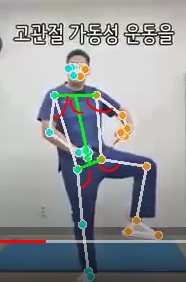

In [16]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

video_path = '하루 5분! 허리디스크 증상 감소 운동 - Trim.mp4' #format 사용 불가능
cap = cv2.VideoCapture(video_path)

#Save results
fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v') 
out = cv2.VideoWriter('%s_output.mp4' % (video_path.split('.')[0]), fourcc, cap.get(cv2.CAP_PROP_FPS), (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))

#Pose model (33 landmarks extraction)
pose = mp_pose.Pose(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5,
    model_complexity=2, enable_segmentation=True) #complexity = 0, 1, 2 (2=> more sophisticated results)

is_first = True # First Frame
#Reference =  coordinates and radius
first_center_x, first_center_y, first_radius = None, None, None
frame_idx = 0
angle_list = {}
while cap.isOpened():
    ret, img = cap.read() #read 
    if not ret:
        break

    img_h, img_w, _ = img.shape #image height and width
    print(img.shape)

    img_result = img.copy() #for the results

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #BGR to RGB 
    results = pose.process(img) #pose processing for getting results

    mp_drawing.draw_landmarks(  #landmark  drawings as a result
        img_result,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS, 
        landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
    
    
    #When landmarks extracted, we will get the size of face
    if results.pose_landmarks:
        # https://google.github.io/mediapipe/solutions/pose.html#pose-landmark-model-blazepose-ghum-3d
        landmark = results.pose_landmarks.landmark

        #Shoulder
        left_shoulder_x = landmark[mp_pose.PoseLandmark.LEFT_SHOULDER].x * img_w #need to multiply as landmark give percentage in 0~255
        left_shoulder_y = landmark[mp_pose.PoseLandmark.LEFT_SHOULDER].y * img_h #we need to change it to pixel

        right_shoulder_x = landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER].x * img_w 
        right_shoulder_y = landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER].y * img_h

        #Hip
        left_hip_x = landmark[mp_pose.PoseLandmark.LEFT_HIP].x * img_w #need to multiply as landmark give percentage in 0~255
        left_hip_y = landmark[mp_pose.PoseLandmark.LEFT_HIP].y * img_h #we need to change it to pixel

        right_hip_x = landmark[mp_pose.PoseLandmark.RIGHT_HIP].x * img_w 
        right_hip_y = landmark[mp_pose.PoseLandmark.RIGHT_HIP].y * img_h

        #Elbow
        left_elbow_x = landmark[mp_pose.PoseLandmark.LEFT_ELBOW].x * img_w #need to multiply as landmark give percentage in 0~255
        left_elbow_y = landmark[mp_pose.PoseLandmark.LEFT_ELBOW].y * img_h #we need to change it to pixel

        right_elbow_x = landmark[mp_pose.PoseLandmark.RIGHT_ELBOW].x * img_w 
        right_elbow_y = landmark[mp_pose.PoseLandmark.RIGHT_ELBOW].y * img_h

        #Knee
        left_knee_x = landmark[mp_pose.PoseLandmark.LEFT_KNEE].x * img_w #need to multiply as landmark give percentage in 0~255
        left_knee_y = landmark[mp_pose.PoseLandmark.LEFT_KNEE].y * img_h #we need to change it to pixel

        right_knee_x = landmark[mp_pose.PoseLandmark.RIGHT_KNEE].x * img_w 
        right_knee_y = landmark[mp_pose.PoseLandmark.RIGHT_KNEE].y * img_h


        #Coordinate of center (midpoint)
        center_shoulder_x = int((left_shoulder_x + right_shoulder_x) / 2)
        center_shoulder_y = int((left_shoulder_y + right_shoulder_y) / 2)

        center_hip_x = int((left_hip_x + right_hip_x) / 2)
        center_hip_y = int((left_hip_y + right_hip_y) / 2)

        #radius = int((left_ear_x - right_ear_x) / 2)
        #radius = max(radius, 20)  #min of radius to 20 pixels

        #Angles
        #Angle between 
        Angle_1 = getAngle(left_elbow_x, left_elbow_y, left_shoulder_x, left_shoulder_y, center_shoulder_x, center_shoulder_y)
        Angle_2 = getAngle(right_elbow_x, right_elbow_y, right_shoulder_x, right_shoulder_y, center_shoulder_x, center_shoulder_y)
        Angle_3 = getAngle(left_knee_x, left_knee_y, left_hip_x, left_hip_y, center_hip_x, center_hip_y)
        Angle_4 = getAngle(right_knee_x, right_knee_y, right_hip_x, right_hip_y, center_hip_x, center_hip_y)
        Angle_5 = getAngle(left_shoulder_x, left_shoulder_y, center_shoulder_x, center_shoulder_y, center_hip_x, center_hip_y)

        if is_first: # Body coordinates of first frame
            first_center_x = center_shoulder_x
            first_center_y = center_shoulder_y
            #first_radius = int(radius * 2) 
            is_first = False
        else:
            #cv2.circle(img_result, center=(first_center_x, first_center_y),radius=first_radius, color=(0, 255, 255), thickness=2)
            #Guideline: What kind of feedback to show
            green = (0,255,0)
            cv2.line(img_result, (int(left_shoulder_x), int(left_shoulder_y)), (int(right_shoulder_x),int(right_shoulder_y)), color = green, thickness=2)
            cv2.line(img_result, (int(left_hip_x), int(left_hip_y)), (int(right_hip_x),int(right_hip_y)), color = green, thickness=2)
            cv2.line(img_result, (center_shoulder_x, center_shoulder_y), (center_hip_x,center_hip_y), color = green, thickness=2)
    
    angle_list[frame_idx] = [Angle_1, Angle_2, Angle_3, Angle_4, Angle_5]
    frame_idx += 1


    cv2_imshow(img_result)
    out.write(img_result)

    if cv2.waitKey(1) == ord('q'):
        break
text_file("output_{}.txt".format(video_path.split('.')[0]), angle_list)

pose.close()
cap.release()
out.release()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#Image png.
thres = 0.5

print(results)
mask_img = (results.segmentation_mask > thres).astype(np.uint8)
bg = draw_background(mask_img)
x = np.repeat(mask_img[:, :, None], 3, axis=2)
# cv2.imwrite(f'{video_file}_mask.png', x[:, :, :, None])

x,y,w,h = cv2.boundingRect(mask_img)
print(x,y,w,h)
min_coor = (x, y)
max_coor = (x+w,y+h)
print("min:", min_coor)
print("max:", max_coor)


# 저장 
video_file = '02_waist'
# red
bg_image = np.repeat(np.zeros_like(mask_img)[:, :, None], 4, axis=2)
#color = tuple(reversed((220,20,60)))
green = (0,255,0)
color = (220,20,60)
cv2.rectangle(bg_image, min_coor, max_coor, color, 2)
# x = np.repeat(bg_image[:, :, :, None], , axis=2)
cv2_imshow(bg_image)
tmp = cv2.cvtColor(bg_image, cv2.COLOR_BGR2GRAY)
_, alpha = cv2.threshold(tmp, 0, 255, cv2.THRESH_BINARY)
b, g, r, a = cv2.split(bg_image)
rgba = [b,g,r,alpha]
dst=cv2.merge(rgba,4)
cv2_imshow(dst)
cv2.imwrite(f'{video_file}_mask_rec_red.png', dst)

# green
bg_image = np.repeat( np.zeros_like(mask_img)[:, :, None], 3, axis=2)
color = tuple(reversed((50,205,50)))
cv2.rectangle(bg_image, min_coor, max_coor, color, 2)

bg_mask = (bg_image > 0).sum(2).astype(np.uint8)
bg_image = np.concatenate((bg_image, np.zeros((bg_image.shape[0], bg_image.shape[1], 1), dtype=bg_image.dtype)), axis=-1)
bg_image[:, :, -1] = bg_mask

cv2.imwrite(f'{video_file}_mask_rec_green.png', bg_image)

fig, axes = plt.subplots(1, 2, figsize=(6, 6))
axes[0].imshow(mask_img, cmap='binary')
axes[1].imshow(bg_image[:, :, :3])

In [17]:
cap = cv2.VideoCapture(0) #real-time camera
thres = 0.5 #threshold for masking
frame_list = [] #Frames of real time camera to compare with ground truth

file_name_ = 'output_하루 5분! 허리디스크 증상 감소 운동 - Trim.txt'

with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5, model_complexity=2, enable_segmentation=True) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        angles = np.zeros((1,4))
        if not ret:
            break

        # Recolor image to RGB
        img_h, img_w, _ = frame.shape #image height and width with _=3
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        
        # Make detection
        results = pose.process(image)

        # Recolor back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Extract landmarks
        try:
            landmarks = results.pose_landmarks.landmark
            
            # Get coordinates
            left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x*img_h,landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y*img_w]
            left_elbow = [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x*img_h,landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y*img_w]
            left_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x*img_h,landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y*img_w]
            left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x*img_h,landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y*img_w]

            right_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x*img_h,landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y*img_w]
            right_elbow = [landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].x*img_h,landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].y*img_w]
            right_knee = [landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].x*img_h,landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].y*img_w]
            right_hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x*img_h,landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y*img_w]
            
            # Calculate angle & Store in (1,4) vector
            angles[0][0] = calculate_angle(left_elbow, left_shoulder, right_shoulder) #angle_1
            angles[0][1]  = calculate_angle(right_elbow, right_shoulder, left_shoulder)
            angles[0][2]  = calculate_angle(left_knee, left_hip, right_hip)
            angles[0][3]  = calculate_angle(right_knee, right_hip, left_hip)         
        except:
            pass

        #1: Setup Box for starting exercise
        mask_img = (results.segmentation_mask > thres).astype(np.uint8)
        x,y,w,h = cv2.boundingRect(mask_img)
        box_ = (x, y, x+w, y+h)
        #Start exercise once shoulders are in box and compare the angles
        if in_box(box_, left_shoulder) and in_box(box_, right_shoulder) and in_box(box_, left_hip) and in_box(box_, right_hip):
            #2: Angle Logic-to compare ground truth
            if frame in frame_list: #frames to compare
                ground_truth = read_groud_truth(file_name_) #Get Matrix of given exercise
                frame_, angle_1, angle_2, angle_3, angle_4, angle_5, _ = ground_truth[frame]
                #ADD: Logic to compare angles with threshold
                #Want to compare angle_1, angle_2, angle_3, angle_4


        # Render detections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2))              
        
        cv2.imshow('Mediapipe', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
            
cap.release()
cv2.destroyAllWindows()